## FINGER TAPPING ANALYSIS
##### Data collected from patients with neurodegenerative disorders as well as healthy controls

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tqdm import tqdm
import os
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import math
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#import tensorflow as tf
#import keras
%matplotlib inline

#### Define MEASUREMENT class and stuff

In [2]:
class measurement:
    def __init__(self, acc1x, acc1y, acc1z, acc2x, acc2y, acc2z, fsr,
                 gyro1x, gyro1y, gyro1z,gyro2x, gyro2y, gyro2z,
                 tap_task, time, time_tap, ttapstart, ttapstop, diagnosis,
                 initials, date, timeOfMeasurement):
        
        # acceleration
        self.acc1x = acc1x # thumb
        self.acc1y = acc1y # thumb
        self.acc1z = acc1z # thumb
        self.acc1Vec = np.sqrt(np.square(self.acc1x)+
                               np.square(self.acc1y)+
                               np.square(self.acc1z))
        
        self.acc2x = acc2x # forefinger
        self.acc2y = acc2y # forefinger
        self.acc2z = acc2z # forefinger
        self.acc2Vec = np.sqrt(np.square(self.acc2x)+
                               np.square(self.acc2y)+
                               np.square(self.acc2z))
        
        # force
        self.fsr = fsr
                
        # angular velocity
        self.gyro1x = gyro1x # thumb
        self.gyro1y = gyro1y # thumb
        self.gyro1z = gyro1z # thumb
        self.gyro1Vec = np.sqrt(np.square(self.gyro1x)+
                                np.square(self.gyro1y)+
                                np.square(self.gyro1z))
        
        self.gyro2x = gyro2x # forefinger
        self.gyro2y = gyro2y # forefinger
        self.gyro2z = gyro2z # forefinger
        self.gyro2Vec = np.sqrt(np.square(self.gyro2x)+
                                np.square(self.gyro2y)+
                                np.square(self.gyro2z))        
        
        # other
        self.tap_task = tap_task # LHEO/LHEC/RHEO/RHEC (left or right hand/eyes open or closed)
        self.time = time
        self.time_tap = time_tap
        self.ttapstart = ttapstart+0.3 #single value, when the actual signal started SECONDS
        self.ttapstop = ttapstop-0.3 #single value, when the actual signal stopped SECONDS
        self.diagnosis = diagnosis # PD, PSP, MSA, CTRL
        self.initials = initials # person name and surname initials 
        self.date = date # date of recording
        self.timeOfMeasurement = timeOfMeasurement #what time that date
        self.length = len(acc1x)
        self.tappingLength = self.ttapstop - self.ttapstart
        self.fs = 200 # sampling rate [Hz]
        self.mvcSustained = max(self.fsr[0:int(ttapstart*self.fs)])
        self.mvcTapping = max(self.fsr[int(ttapstart*self.fs):int(ttapstop*self.fs)])
        #self.mvcTotal = self.mvcTapping if self.mvcTapping>self.mvcSustained else self.mvcSustained
        self.normalizedFSR = self.fsr/self.mvcSustained
        self.id = self.diagnosis + '_' + self.initials + '_' +self.date 
        
    def packAndCrop(self, seconds):
        
        # matrix for feeding into a net
        # shape: 13 x seconds*SamplingRate
        
        allPacked = np.concatenate(([self.acc1x], [self.acc1y], [self.acc1z],
                                             [self.acc2x], [self.acc2y], [self.acc2z],
                                             [self.gyro1x],[self.gyro1y], [self.gyro1z],
                                             [self.gyro2x],[self.gyro2y], [self.gyro2z],
                                             [self.normalizedFSR]), axis=0) 
        
        allPacked = allPacked[:, int(self.fs*self.ttapstart):int(self.fs*self.ttapstop)]
        
        crops = []
        
        modelPackage = np.zeros((13,seconds*self.fs),dtype='float16')
        fin = allPacked.shape[1] if allPacked.shape[1]<seconds*self.fs else seconds*self.fs
        modelPackage[:,:fin] = allPacked[:,:fin]
        
        crops.append(modelPackage)
        
        nCrops = int((allPacked.shape[1] - seconds*self.fs)/self.fs)
        for i in range(nCrops):
            crops.append(allPacked[:,((i+1)*self.fs):((i+1)*self.fs + seconds*self.fs)])
            
        
        return crops
       
    def sumUp(self):
        temp = {'lenAccThumb': len(self.acc1x),
               'lenAccForefinger': len(self.acc2x),
               'lenFsr': len(self.fsr),
               'lenGyroThumb': len(self.gyro1x),
               'lenGyroForefinger': len(self.gyro2x),
               'lenTime': len(self.time)}
        temp['MATCHING_LENGTHS'] =  len(set(temp.values()))==1
        temp['durationInSecs'] = self.length/self.fs
        return temp
    
    def plotSignals(self, xlim = []):
        # Optionally pass a tuple for zooming in on the x axis (xmin,xmax)
        if len(xlim) <2:
            xlim = (0,self.length/self.fs)
            
        # accelerometers     
        plt.figure(figsize=(16,12))
        plt.plot(self.time,self.acc1x)
        plt.plot(self.time,self.acc1y)
        plt.plot(self.time,self.acc1z)
        plt.plot(self.time,self.acc2x)
        plt.plot(self.time,self.acc2y)
        plt.plot(self.time,self.acc2z)
        plt.axvline(x = self.ttapstart,color = 'b')
        plt.axvline(x = self.ttapstop, color = 'r')
        plt.xlim(xlim)
        plt.legend(('AccThumbX', 'AccThumbY', 'AccThumbZ',
                    'AccIndexX', 'AccIndexY', 'AccIndexZ'))
        plt.title('Accelerometers for subject ' + self.initials +
                  ' Date: ' + self.date +
                  ' Diagnosis: ' + self.diagnosis +
                   'Task: ' + self.tap_task)
        plt.show()
        
        # vector accelerometer
        plt.figure(figsize=(16,5))
        plt.plot(self.time, self.acc1Vec)
        plt.plot(self.time, self.acc2Vec)
        plt.axvline(x = self.ttapstart,color = 'b')
        plt.axvline(x = self.ttapstop, color = 'r')
        plt.xlim(xlim)
        plt.legend(('AccThumbVector', 'AccIndexVector'))
        plt.title('Accelerometer Vectors')
        plt.show()
        
        # gyros
        plt.figure(figsize = (16,5))
        plt.plot(self.time,self.gyro1x)
        plt.plot(self.time,self.gyro1y)
        plt.plot(self.time,self.gyro1z)
        plt.plot(self.time,self.gyro2x)
        plt.plot(self.time,self.gyro2y)
        plt.plot(self.time,self.gyro2z)
        plt.legend(('GyroThumbX', 'GyroThumbY', 'GyroThumbZ',
                    'GyroIndexX', 'GyroIndexY', 'GyroIndexZ'))
        plt.axvline(x = self.ttapstart,color = 'b')
        plt.axvline(x = self.ttapstop, color = 'r')
        plt.xlim(xlim)
        plt.title('Gyro data')
        
        # vector gyro
        plt.figure(figsize=(16,5))
        plt.plot(self.time, self.gyro1Vec)
        plt.plot(self.time, self.gyro2Vec)
        plt.axvline(x = self.ttapstart,color = 'b')
        plt.axvline(x = self.ttapstop, color = 'r')
        plt.xlim(xlim)
        plt.legend(('GyroThumbVector', 'GyroIndexVector'))
        plt.title('Gyro Vectors')
        plt.show()
        
        # force
        plt.figure(figsize=(16,5))
        plt.plot(self.time,self.normalizedFSR)
        plt.xlim(xlim)
        plt.axvline(x = self.ttapstart,color = 'b')
        plt.axvline(x = self.ttapstop, color = 'r')
        plt.title('Normalized FSR')
        plt.show()
    

        
        
    

In [3]:
def readAdjust(root, directory, file):
    
    sig = scipy.io.loadmat(root + directory + '/' + file)
    
    temp = measurement(sig['acc1'][0],
                       sig['acc1'][1],
                       sig['acc1'][2],
                       sig['acc2'][0],
                       sig['acc2'][1],
                       sig['acc2'][2],
                       sig['fsr'][0],
                       sig['gyro1'][0],
                       sig['gyro1'][1],
                       sig['gyro1'][2],
                       sig['gyro2'][0],
                       sig['gyro2'][1],
                       sig['gyro2'][2],
                       sig['tap_task'][0], 
                       sig['time'][0],
                       sig['time_tap'][0],
                       sig['ttapstart'][0,0], 
                       sig['ttapstop'][0,0], 
                       directory,
                       file[0:2], 
                       file[3:13],
                       file[14:22])
                           
    return temp
    

#### READ THE DATA

In [4]:
root = 'C:/Users/Korisnik/Desktop/Minjino/Tapping/Tapping raw data/'


In [5]:
_,dirs,_ = os.walk(root).__next__()

sigs = []
for d in tqdm(dirs):
    _,_,files = os.walk(root+d).__next__()
    sigs = sigs +[readAdjust(root, d, file) for file in files]
    
    

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


##### Check if everything's okay.

In [ ]:
sigs[12].sumUp()

In [ ]:
print('INFO:')
print('There are a total of {} files'.format(len(sigs)))

temp = [s.sumUp()['MATCHING_LENGTHS'] for s in sigs]
if len(set(temp))==1:
    print('All signals contain accelerometer, gyro and fsr data of the same length')
else:
    print('Some files contain data of unequal lengths')


    

In [ ]:
sigs[8].plotSignals([0,10])

### How does force behave in regard to maximal force exerted in sustained vs tapping conditions?

In [ ]:
diags = []
ratios = np.array([],dtype =  'int64')
mvs = []
mvt =[]
task = []
for sig in sigs:
    diags.append(sig.diagnosis)
    ratios = np.append(ratios,sig.mvcSustained/sig.mvcTapping)
    mvs.append(sig.mvcSustained)
    mvt.append(sig.mvcTapping)
    task.append(sig.tap_task)

 

#### Max sustained force. Max tapping force.

In [ ]:
plt.figure(figsize = (10,6))
sns.boxplot(x = diags, y = mvs, hue = task)
plt.title('Maximal force during sustained contraction by task')
plt.show()

plt.figure(figsize = (10,6))
sns.boxplot(x = diags, y = mvt, hue = task)
plt.title('Maximal force during tapping by task')
plt.show()

#### Max sustained over max tapping force

In [ ]:
plt.figure(figsize = [15,9])
sns.boxplot(x = diags, y = ratios, hue = task)
plt.axhline(y = 1, color = 'k')
plt.ylim([-2,10])
plt.title('Sustained max/Tapping max ratio')
plt.show()

More than 50% of CTRL and PD participants present higher force during tapping than during sustained maximal voluntary contraction, for all tasks (Ratio <1). This is not the case in MSA and PSP. 
This relation is preserved when no task separation is performed, but the line representing ratio of 1 is now closer to the median (fig below).

Controls have a stable ratio over all tasks. 
The ratio has larger excursions into the positive values for PD patients when their eyes are open. 
PSP patients seem to have pronounced lateral differences.

In [ ]:
plt.figure(figsize = [15,9])
sns.boxplot(x = diags, y = ratios)
plt.axhline(y = 1, color = 'k')
plt.ylim([-2,10])
plt.title('Sustained max/Tapping max ratio over all tasks')
plt.show()

Grouping by task:

In [ ]:
plt.figure(figsize = [15,9])
sns.boxplot(x = task, y = ratios, hue = diags)
plt.axhline(y = 1, color = 'k')
plt.ylim([-2,10])
plt.title('Sustained max/Tapping max ratio')
plt.show()

#### Check normality

In [ ]:
# smash these arrays into a dataframe for grouping

dfForce = pd.DataFrame({'diagnosis':diags,
                        'ratio':ratios ,
                        'MaxSustained': mvs ,
                        'MaxTapping': mvt,
                        'task': task})

dfG = pd.DataFrame(dfForce.groupby(['diagnosis','task'])['ratio'].mean())


In [ ]:
print(dfG)

In [ ]:
dfG = dfG.ratio

In [ ]:
dfG['CTRL']

In [ ]:
dfG['CTRL']['LHEC']

In [ ]:
residuals = []
for i,diag in enumerate(diags):
    tempTask = task[i]
    residuals.append(ratios[i]-dfG[diag][tempTask])

In [ ]:
plt.plot(residuals)
plt.title('Residuals of the mvcSustained/mvcTapping ratio in reference to the corresponding diagnosis+task')
plt.show()

In [ ]:
a = plt.hist(residuals,bins=50)
plt.title('Histogram of residuals')
plt.show()
a

In [ ]:
stats.shapiro(residuals)

Well of course, totally not normally distributed.

##### Log/sqrt transform data.

In [ ]:
logRatios = np.sqrt(5+np.log(ratios))
dfForceLog = pd.DataFrame({'diagnosis':diags,
                        'ratio':logRatios,
                        'MaxSustained': mvs,
                        'MaxTapping': mvt,
                        'task': task})

dfGLog = pd.DataFrame(dfForceLog.groupby(['diagnosis','task'])['ratio'].mean())
dfGLog = dfGLog.ratio
print(dfGLog)
residualsLog = []
for i,diag in enumerate(diags):
    tempTask = task[i]
    residualsLog.append(logRatios[i]-dfGLog[diag][tempTask])

In [ ]:
plt.plot(residualsLog)
plt.title('Residuals of log transformed ratios')
plt.show()

In [ ]:
logHist = plt.hist(residualsLog,bins = 50)

In [ ]:
stats.shapiro(residualsLog)

Erm...still officially not normal?

In [ ]:
stats.kurtosis(residualsLog)

In [ ]:
stats.skew(residualsLog)

But since skewness and kurtosis are alright (internet says up to +-2), I'm gonna do ANOVA anyway. 

In [ ]:
# Let's see how the data changed

plt.figure(figsize = [15,9])
sns.boxplot(x = diags, y = logRatios, hue = task)
plt.axhline(y = math.sqrt(5), color = 'k') # 5 jer log(1)=0
plt.ylim([0,4])
plt.title('Sustained max/Tapping max ratio after sqrt+log transform')
plt.show()

In [ ]:
lm = ols('ratio ~ task+diagnosis+task*diagnosis', data = dfForceLog).fit()
table = sm.stats.anova_lm(lm, typ=2) # Type 2 ANOVA DataFrame

In [ ]:
table

So there appears to be no significant differences between tasks, nor diagnosis*task interaction.
BUT. THese data are not paired. Need to group by individuals to test for differences in tasks. 
However, there is a significant effect in diagnosis disregarding pairing. 

In [ ]:
ctrlRatio = dfForceLog[dfForceLog.diagnosis == 'CTRL']['ratio']
pdRatio = dfForceLog[dfForceLog.diagnosis == 'PD']['ratio']
msaRatio = dfForceLog[dfForceLog.diagnosis == 'MSA']['ratio']
pspRatio = dfForceLog[dfForceLog.diagnosis == 'PSP']['ratio']

CPD = stats.ttest_ind(ctrlRatio, pdRatio)  
CMSA = stats.ttest_ind(ctrlRatio, msaRatio) 
CPSP = stats.ttest_ind(ctrlRatio, pspRatio) 
PDMSA = stats.ttest_ind(pdRatio, msaRatio) 
PDPSP = stats.ttest_ind(pdRatio, pspRatio) 
MSAPSP = stats.ttest_ind(msaRatio, pspRatio) 




In [ ]:
pvals = [CPD.pvalue, CMSA.pvalue, CPSP.pvalue, PDMSA.pvalue, PDPSP.pvalue, MSAPSP.pvalue]
pvals

In [ ]:
# Correct for multiple testing
multipletests(pvals, alpha=0.05, method='bonferroni')

So...apparently there is a significant difference(for alpha level 0.05) (even if bonferroni corrected) between CTRL and MSA. ALso CTRL and PSP.
But not CTRL and PD.

There is a difference between PSP and PD, but not PSP and MSA, nor PD and MSA. 
If we take a less strict method of correction, such as 'holm' we get significant differences between all groups except PD and CTRL.

In [ ]:
multipletests(pvals, alpha=0.05, method='holm')

The most certain are differences between CTRL and PSP, as well as PD and PSP.
(p< e-06)

In [ ]:
means = [np.mean(ctrlRatio), np.mean(pdRatio), np.mean(msaRatio), np.mean(pspRatio)]
plt.bar(['CTRL','PD','MSA','PSP'],means)
plt.axhline(y = math.sqrt(5), color = 'k')
plt.title('Mean transformed sustained/tapping ratio ratio')
plt.show()

### Group by patient

In [ ]:
class person:
    
    def __init__(self,pID):
        self.id = pID
        self.signals = []
        
    def addSignals(self, sig):
        self.signals.append((sig.tap_task,sig))
        
        
        

In [ ]:
uniqueIds = set([sig.id for sig in sigs])
persons = []
for personID in uniqueIds:
    p = person(personID)
    for sig in sigs:
        if sig.id == personID:
            p.addSignals(sig)
            
    persons.append(p)       
    

In [ ]:
persons[3].__dict__.keys()


In [ ]:
persons[33].signals

In [ ]:
persons[21].signals

Some persons don't have all tasks. Some have several signals for each task. Remove those with missing data.

In [ ]:
validPersons = []
for person in persons:
    if len(set(person.signals[i][0] for i in range(len(person.signals))))==4:
        validPersons.append(person)

In [ ]:
len(validPersons), len(persons)

Arite, so we got rid of 9 persons. Oh well. 

In [ ]:
validPersons[40].signals

Take one of each task.

In [ ]:
validPersonsOneEach = []
for person in validPersons:
    added = {'LHEO':0,'LHEC':0,'RHEO':0,'RHEC':0}
    temp = []
    for sig in person.signals:
        if added[sig[0]]==0:
            added[sig[0]]=1
            temp.append(sig)
    person.oneSignalEachTask = temp
    validPersonsOneEach.append(person)
    
            

In [ ]:
validPersonsOneEach[0].oneSignalEachTask

In [ ]:
# samo signali


In [ ]:
# Statsmodels doesn't support repeated measures -__-
# Find something else
# repack and export to R

pid = []
diagnosis = []
task = []
signal = []
mvcRatio = []
for person in validPersonsOneEach:
    taskovi, signali = zip(*person.oneSignalEachTask)
    task+= taskovi
    signal+=signali
    for s in signali:
        mvcRatio.append(np.sqrt(5+np.log(s.mvcSustained/s.mvcTapping)))
    for i in range(4):
        diagnosis.append(signali[0].diagnosis)
        pid.append(signali[0].id)
    
dfExport = pd.DataFrame(np.column_stack([pid,diagnosis,task,mvcRatio]),
                     columns = ['pID','diagnosis','task','mvcRatio'])
dfExport.to_csv('zaRmvc.csv',index=False)

In [ ]:
dfExport.head()

Checked repeated measures in R, and still no significant effect.

But maybe not enough data now that I only kept one of each. On such a mutilated set, even diagnosis comparisons are barely significant. 

Also, not equal number of patients per group, maybe pick 40 of each group. 

Check the outliers. 

Also check variances and stuff and then redo the statistical analysis.

For the time being, it seems appropriate to include FSR data into the model, but perhaps treating all tasks as equal, since there seems to be no meaningful difference between them. But, is this the case for other signals too? 


#### Repacking for ML

In [6]:
# Minimal length of signals?

m = 10000
i = 1
for ix,sig in enumerate(sigs):
    if sig.tappingLength < m:
        m = sig.tappingLength
        i = ix
        
# The shortest signal is sigs[86], corresponding to a CTRL, rhec. Lasts a total of 12s, and 7.25s of active tapping.
# Going to remove those with active signal <10s
# Crop signals into new data. Take 8s of data, overlap by 1s. 


In [7]:
def encodeDiagnosis(diagnosis):
    le = LabelEncoder()
    le.fit(['CTRL','MSA','PD','PSP'])
    # This is the encoding:
    # CTRL -----> 0 -----> [1,0,0,0]
    # MSA ----->  1 -----> [0,1,0,0]
    # PD -----> 2 -----> [0,0,1,0]
    # PSP -----> 3 -----> [0,0,0,1]
    
    diagnosis = le.transform([diagnosis])
    oneHotDiagnosis = np.zeros((1,4),dtype='uint8')
    idx = diagnosis[0]
    oneHotDiagnosis[0][idx] = 1
    return oneHotDiagnosis[0]

  
    

In [8]:

X = []  # signals
Y = []  # diagnoses
nSeconds = 13
for sig in sigs:
    crops = sig.packAndCrop(nSeconds)
    for crop in crops:
        X.append(crop)
        Y.append(encodeDiagnosis(sig.diagnosis))
    
Y = np.reshape(Y,(len(Y),4))

# Cannot reshape X, memory error.
# Try splitting into train, test, val first

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.3, random_state=1)
Xtest, Xval, Ytest, Yval = train_test_split(Xtest, Ytest, test_size = 0.2, random_state =1)

Xval = np.array(Xval)
Xtest = np.array(Xtest)

# erm, still too much?

batch1 = Xtrain[:int(len(Xtrain)/3)]
batch2 = Xtrain[int(len(Xtrain)/3):2*int(len(Xtrain)/3)]
batch3 = Xtrain[2*int(len(Xtrain)/3):]

batch1 = np.array(batch1)
batch2 = np.array(batch2)
batch3 = np.array(batch3)

#can only run this once :/ because memory error

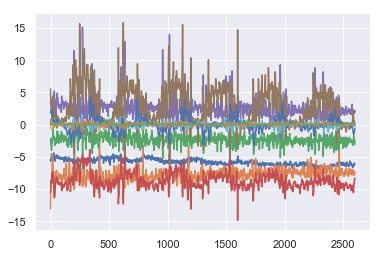

In [18]:
plt.plot(batch3[111].T)
plt.show()

In [19]:
import sys
sys.getsizeof(batch1)

135200064

Whyyyyyyyyyyyy